In [23]:
import io
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [51]:
# Run this to ensure TensorFlow 2.x is used
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

Context

Opportunities to analyze the general market based on sentiment analysis of news exist plentifully, but there are few opportunities to discover or predict the performance of a specific stock based on relevant headlines. This by-company prediction is more useful to users than general binary classifications of an entire market - but I found in my research that properly labeled data for this use case didn't exist publicly.

Content

Using web scraping methods written by colleague Yin Chang, we were able to obtain news headlines from Reddit r/WorldNews, as well as corresponding market data through Yahoo Finance. With these two vital pieces, I was able to then write this data.


Each headline corresponds with a stock symbol (currently only tracking US markets - companies represented by the NASDAQ and DJIA) and a sentiment label. The sentiment labels are as follows:

0 -> The stock went down by market close the day the article was published (negative)

1 -> The stock went up by market close the day the article was published (positive)

2 -> The stock stayed the same by market close the day the article was published (neutral)

Note: We will be removing entries labeled 2, since there are fewer and we would like to make the output binary.

Original Source: https://www.kaggle.com/sidarcidiacono/news-sentiment-analysis-for-stock-data-by-company

In [118]:
news1 = pd.read_csv('./djia_news/djia_news copy.csv')
news2 = pd.read_csv("./nasdaq/nasdaq.csv")
combined_news = news1.append(news2)
combined_news = combined_news[combined_news.Label != 2]
news_train, news_test = train_test_split(combined_news,test_size = .20, random_state = 1)

In order to predict the sentiment, we split the data between train/test.
We will not allow our model to see test data.

In [119]:
labels_train = news_train['Label'].tolist() # separating each column into a list
ticker_train = news_train['Ticker'].tolist()
headline_train = news_train['Headline'].tolist()
labels_test = news_train['Label'].tolist() # testing data
ticker_test = news_train['Ticker'].tolist()
headline_test = news_train['Headline'].tolist()

Here we fit a tokenizer on the training headlines and then use that tokenizer to padded training and testing sequences.

In [146]:
vocab_size = 15000
tokenizer = Tokenizer(num_words = vocab_size, oov_token = "<OOV>")
tokenizer.fit_on_texts(headline_train)
word_index = tokenizer.word_index

train_sequence = tokenizer.texts_to_sequences(headline_train)
train_padded = pad_sequences(train_sequence, padding = "post", truncating = 'post')

test_sequence = tokenizer.texts_to_sequences(headline_test)
test_padded = pad_sequences(test_sequence, padding = "post",truncating = 'post')

In [147]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 16, input_length = 100),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24,activation= 'relu'),
    tf.keras.layers.Dense(1,activation = 'sigmoid')
])
model.compile(loss = 'binary_crossentropy',optimizer = 'adam',metrics = ['accuracy'])

In [148]:
model.summary()
train_padded = np.array(train_padded)
labels_train = np.array(labels_train)
test_padded = np.array(test_padded)
labels_test = np.array(labels_test)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 100, 16)           240000    
_________________________________________________________________
global_average_pooling1d_9 ( (None, 16)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 24)                408       
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 25        
Total params: 240,433
Trainable params: 240,433
Non-trainable params: 0
_________________________________________________________________


In [149]:
num_epochs = 30
history = model.fit(train_padded, labels_train, epochs=num_epochs, validation_data=(test_padded, labels_test), verbose=2)

Epoch 1/30
381/381 - 1s - loss: 0.6475 - accuracy: 0.6581 - val_loss: 0.6368 - val_accuracy: 0.6582
Epoch 2/30
381/381 - 1s - loss: 0.6316 - accuracy: 0.6582 - val_loss: 0.6166 - val_accuracy: 0.6582
Epoch 3/30
381/381 - 1s - loss: 0.5855 - accuracy: 0.6744 - val_loss: 0.5156 - val_accuracy: 0.7542
Epoch 4/30
381/381 - 1s - loss: 0.4768 - accuracy: 0.7709 - val_loss: 0.4038 - val_accuracy: 0.8130
Epoch 5/30
381/381 - 1s - loss: 0.3926 - accuracy: 0.8239 - val_loss: 0.3350 - val_accuracy: 0.8597
Epoch 6/30
381/381 - 1s - loss: 0.3435 - accuracy: 0.8460 - val_loss: 0.2926 - val_accuracy: 0.8819
Epoch 7/30
381/381 - 1s - loss: 0.3018 - accuracy: 0.8663 - val_loss: 0.2618 - val_accuracy: 0.8900
Epoch 8/30
381/381 - 1s - loss: 0.2715 - accuracy: 0.8839 - val_loss: 0.2425 - val_accuracy: 0.8967
Epoch 9/30
381/381 - 1s - loss: 0.2477 - accuracy: 0.8908 - val_loss: 0.2200 - val_accuracy: 0.9052
Epoch 10/30
381/381 - 1s - loss: 0.2282 - accuracy: 0.8996 - val_loss: 0.1964 - val_accuracy: 0.9186

Based on the graphs below, we can determine that the accuracy stabilizes around 15-20 Epochs

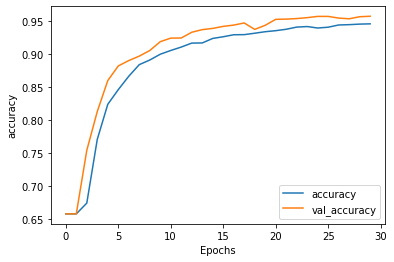

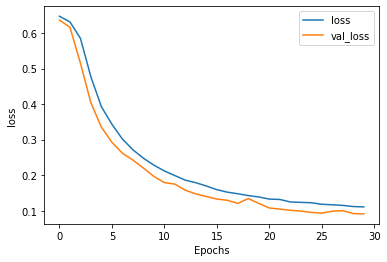

In [150]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

We will now test this model by applying new data. Printed is the probability that your output = 1 (The stock went up by market close the day the article was published).

Note that the further our prediction is from either 1 or 0, the more uncertainty there is. There could be a possibility of its label being 2 (The stock stayed the same by market close the day the article was published (neutral)), but this model is not made to predict that label.

These headlines were taken from Yahoo! Finance.  

In [151]:
sentence = ["Intel Stock Is Sliding Because Its Problems Are Big Problems and the Solutions Aren’t Easy", "Ford Stock Gets Bump From Electric F-150 Unveiling Announcement"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=100, padding='post', truncating='post')
prediction = model.predict(padded)
result = []
j=0
for i in prediction:
    if i > 0.5:
        result.append('Positive Sentiment')
    else:
        result.append('Negative Sentiment')
    j=+1

In [152]:
j = 0
for i in sentence:
    print(i,":",result[j])
    j=+1

Intel Stock Is Sliding Because Its Problems Are Big Problems and the Solutions Aren’t Easy : Negative Sentiment
Ford Stock Gets Bump From Electric F-150 Unveiling Announcement : Positive Sentiment


In [153]:
prediction

array([[2.8715647e-06],
       [6.0994238e-01]], dtype=float32)